In [1]:
import numpy as np
import numexpr as ne

Įmonė ,,Geognitis" gauna duomenis iš palydovo apie agrokultūras, auginamas Lietuvos sklypuose. Duomenis apie sklypų geografinį išsidėstymą galima parsisiųsti iš tam tikro serverio `.tiff` (nuotraukos) formatu. Iš tokių failų galima gana greitai nuskaityti dvimatį apytiksliai $30000\times 40000$ dydžio `numpy` masyvą, kurio reikšmės yra `np.int32` tipo sveikieji skaičiai. Tai padarius paaiškėjo, kad apie 95% duomenų sudaro reikšmės, lygios -2147483648:

    >>> np.array([2**31-1], dtype=np.int32)
    array([2147483647])
    >>> example + 1
    array([-2147483648])
    
Šios reikšmės atitinka vieno aro žemės plotus, neturinčius duomenų apie jiems priskirtus sklypus. Visos kitos reikšmės - sveikieji skaičiai tarp 7000000 ir 8000000, atitinkantys kiekvienam arui priskirto sklypo numerį. 

Masyvui saugoti reikia $30000\times 40000 \times 4 = 4.8GB$ vietos. Tai labai stabdo tolimesnį duomenų procesinimą ir eikvoja atminties vietą diske. Todėl jūsų tikslas - kiek įmanoma sumažinti atminties resursus. Duomenų procesinimui užtenka naudoti tik 5 % duomenų: reikšmes, nelygias -2147483648. 

Parašykite programą, kuri sutraukia bet kurį pradinį $N\times M$ matmenų masyvą $X$ į kuo mažiau atminties reikalaujančius kintamuosius, pakankamus atkurti $X$. Atkuriant $X$ laiko ir atminties taupymo sumetimais -2147483648 galima pakeisti į 0.

## Input

    N, M = 20, 8
    X = np.random.choice(np.array([-2147483648, 0]), p=[0.95, 0.05], size=(N,M))
    idx1, idx2 = np.nonzero(X == 0)
    X[idx1, idx2] = np.random.randint(7000000, 8000000, size=len(idx1))
    with np.printoptions(linewidth=150):
        print(f'X = np.array(\n{np.array2string(X, separator=", ")})')

or:

In [173]:
X = np.array(
[[-2147483648, -2147483648, -2147483648, -2147483648, -2147483648, -2147483648, -2147483648, -2147483648],
 [-2147483648, -2147483648, -2147483648, -2147483648, -2147483648, -2147483648, -2147483648,     7227728],
 [-2147483648, -2147483648, -2147483648, -2147483648, -2147483648, -2147483648, -2147483648,     7245152],
 [-2147483648, -2147483648, -2147483648, -2147483648, -2147483648, -2147483648, -2147483648, -2147483648],
 [-2147483648, -2147483648, -2147483648, -2147483648, -2147483648, -2147483648, -2147483648, -2147483648],
 [-2147483648, -2147483648,     7605751, -2147483648, -2147483648, -2147483648, -2147483648, -2147483648],
 [-2147483648, -2147483648, -2147483648, -2147483648,     7399137, -2147483648, -2147483648, -2147483648],
 [-2147483648, -2147483648, -2147483648, -2147483648, -2147483648, -2147483648, -2147483648, -2147483648],
 [-2147483648, -2147483648, -2147483648, -2147483648, -2147483648, -2147483648, -2147483648, -2147483648],
 [-2147483648, -2147483648, -2147483648, -2147483648, -2147483648, -2147483648, -2147483648, -2147483648],
 [-2147483648, -2147483648, -2147483648, -2147483648, -2147483648, -2147483648, -2147483648, -2147483648],
 [-2147483648, -2147483648, -2147483648, -2147483648, -2147483648, -2147483648, -2147483648, -2147483648],
 [    7954246, -2147483648, -2147483648, -2147483648, -2147483648, -2147483648, -2147483648, -2147483648],
 [-2147483648, -2147483648, -2147483648, -2147483648,     7119663, -2147483648, -2147483648, -2147483648],
 [-2147483648, -2147483648, -2147483648,     7422587, -2147483648, -2147483648, -2147483648, -2147483648],
 [-2147483648, -2147483648, -2147483648, -2147483648, -2147483648, -2147483648, -2147483648, -2147483648],
 [-2147483648, -2147483648, -2147483648, -2147483648, -2147483648, -2147483648,     7779695, -2147483648],
 [-2147483648, -2147483648, -2147483648,     7945685, -2147483648, -2147483648, -2147483648, -2147483648],
 [-2147483648, -2147483648, -2147483648, -2147483648, -2147483648, -2147483648, -2147483648, -2147483648],
 [-2147483648, -2147483648, -2147483648, -2147483648, -2147483648,     7801227, -2147483648, -2147483648]])

### Output
Bet kokie kintamieji, užimantys kuo mažiau vietos, iš kurių galima atkurti X. 

### Solutions

In [44]:
#SIMULATE DATA:
N, M = 10000, 10000
X = np.random.choice(np.array([-2147483648, 0]), p=[0.95, 0.05], size=(N,M))
idx1, idx2 = np.nonzero(X == 0)
X[idx1, idx2] = np.random.randint(7000000, 8000000, size=len(idx1))

**Technologijos, kurias naudoja `numpy` (duomenys neužnulinami)**

In [5]:
def numpy_save(arr, name='compressions/numpy_save_geodata'):
    np.save(name, arr)
    
def numpy_load_npy(name='compressions/numpy_save_geodata.npy'):
    return np.load(name)

numpy_save(X)
numpy_load_npy().shape

(10000, 10000)

In [6]:
def numpy_savez(arr, name='compressions/numpy_savez_geodata'):
    np.savez(name, arr=arr)
    
def numpy_load_npz(name = 'compressions/numpy_savez_geodata.npz'):
    load_data = np.load(name)
    return load_data['arr']

numpy_savez(X)
numpy_load_npz().shape

(10000, 10000)

In [8]:
def numpy_savez_compressed(arr, name='compressions/numpy_savez_compressed_geodata'):
    np.savez_compressed(name, arr=arr)
    
def numpy_load_npz(name = 'compressions/numpy_savez_compressed_geodata.npz'):
    load_data = np.load(name)
    return load_data['arr']

numpy_savez_compressed(X)
numpy_load_npz().shape

(10000, 10000)

**Technologijos, kurias įmanoma pasidaryti rankomis atsižvelgiant į duomenų pobūdį**. Some cheats:
* Prieš sutraukiant duomenis atimamas mažiausias narys, kad jie būtų mažesni, o išskleidžiant - vėl pridedamas
* Žinant mažiausio nario reikšmę 7000000, neeikvojamas laikas `np.min` funkcijai
* `numexpr.evaluate` ne tik sparčiau tvarkosi su duomenų atkūrimu, bet ir išsprendžia tipų nesusiderinimo problemas, kurios kiltų analogiškus skaičiavimus darant per `numpy`.
* Naudojamas skaidymas į stulpelius, kurių reikšmės neperžengia `(256, 256, 2, 2, 2, 2)`. Tai galima daryti tik būnant tikriems, kad duomenų diapazonas mažesnis už $2^{20} = 1048576$
* `np.unravel_index(arr - minimum, (256, 256, 2, 2, 2, 2))` ateityje galima padaryti multicore.

In [11]:
def _binary_pack(arr, minimum=7000000):
    a,b,c,d,e,f = np.unravel_index(arr - minimum, (256, 256, 2, 2, 2, 2))
    a,b,c,d,e,f = a.astype(np.uint8), b.astype(np.uint8), np.packbits(c), np.packbits(d), np.packbits(e), np.packbits(f)
    return a,b,c,d,e,f

def _binary_unpack(columns, minimum=7000000):
    a,b,c,d,e,f = columns #I know that shape is going to be (256, 256, 2, 2, 2, 2)
    c,d,e,f = np.unpackbits(c, count=a.size), np.unpackbits(d, count=a.size), np.unpackbits(e, count=a.size), np.unpackbits(f, count=a.size)
    return ne.evaluate('minimum+4096*a+16*b+8*c+4*d+2*e+f', {'a':a, 'b':b, 'c':c, 'd':d, 'e':e, 'f':f,'minimum':minimum})

def numpy_pack_geotiff(arr, name='compressions/numpy_pack_geotiff', compress=False, zero_val=-2147483648):
    '''converts geotiff data into the smallest possible structure and saves it'''
    arr_ravel = arr.ravel()
    idx = arr_ravel != zero_val #TARGET 1
    idx_pack = np.packbits(idx) 
    values = arr_ravel[idx] #TARGET 2
    del idx
    v0_pack, v1_pack, v2_pack, v3_pack, v4_pack, v5_pack = _binary_pack(values)
    shape = np.array(arr.shape)
    if compress: np.savez_compressed(name, idx_pack=idx_pack, shape=shape,
                  v0_pack=v0_pack, v1_pack=v1_pack, v2_pack=v2_pack, v3_pack=v3_pack, v4_pack=v4_pack, v5_pack=v5_pack)
    else: np.savez(name, idx_pack=idx_pack, shape=shape,
                  v0_pack=v0_pack, v1_pack=v1_pack, v2_pack=v2_pack, v3_pack=v3_pack, v4_pack=v4_pack, v5_pack=v5_pack)
    
def numpy_unpack_geotiff(name='compressions/numpy_pack_geotiff.npz'):
    '''retrieves geotiff data from saved file'''
    load_data = np.load(name)
    idx = np.unpackbits(load_data['idx_pack']).astype(bool)
    values = _binary_unpack((load_data[f'v{n}_pack'] for n in range(6)))
    shape = load_data['shape']
    return idx, values, shape

def numpy_restore_geotiff(idx, values, shape):
    '''restores missing data of geotiff to make it 100% initial tiff'''
    Z = np.zeros(shape, dtype=int)
    Z.ravel()[idx] = values
    return Z

#numpy_pack_geotiff(X, compress=False) ## 1.79 secs
#idx, values, shape = numpy_unpack_geotiff() ## 0.5 secs
#XX = numpy_restore_geotiff(idx, values, shape) ## 0.5 secs
#XX[XX == 0] = -2147483648 
#np.array_equal(X, XX)

In [57]:
%%timeit -n 1 -r 1
numpy_pack_geotiff(X, compress=False)

1.79 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [60]:
%%timeit -n 1 -r 1
idx, values, shape = numpy_unpack_geotiff()

473 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [62]:
%%timeit -n 1 -r 1
numpy_restore_geotiff(idx, values, shape)

443 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Real work with real big data

Nusiskaitom masyvą iš 4GB dydžio failo. 

In [2]:
from osgeo import gdal
from time import time

#path = 'paseliai/clf_LIT_2021_ET100_18pas.tif'
path = 'paseliai/paseliai_2020_sklypo_ID.tif'

def read_raster_arr(path):
    '''returns array of blocks'''
    ds = gdal.OpenEx(path, gdal.GA_ReadOnly) #raster_dataset
    band = ds.GetRasterBand(1)
    return band.ReadAsArray()

def read_raster_gen(path):
    '''returns generator of blocks'''
    ds = gdal.OpenEx(path, gdal.GA_ReadOnly) #raster_dataset
    band = ds.GetRasterBand(1)
    w1, w2 = band.GetBlockSize()
    for i in range(0, ds.RasterXSize, w1):
        for j in range(0, ds.RasterYSize, w2):
            yield band.ReadAsArray(i, j, w1, w2)
            
t = time()
arr = read_raster_arr(path)
print('arr done, time:', round(time()-t,3))

arr done, time: 59.919


Reikia ištaisyti kelias klaideles:
* Iš tiesų duomenys yra ne `np.int32`, o `np.uint32` tipo. Tai reiškia, kad dauguma skaičių bus lygūs 4294967295.
* Pastebim, kad tarpas tarp min ir max yra apie 1200000. Imsime duomenų formatą, kai vienam skaičiui įsiminti skiriama 3 baitai (o ne 2 baitai ir 5 bitai). 
* Masyvo dydis ne visada dalijasi iš 8. Šiuo atveju jo forma (28659, 37942). Todėl reikia nustatyti `count=np.prod(shape)` parametrą išpakuojant jo `bool` tipo indeksus.

In [59]:
def _sklypo_pack(arr):
    a,b,c = np.unravel_index(arr, (256, 256, 256))
    a,b,c = a.astype(np.uint8), b.astype(np.uint8), c.astype(np.uint8)
    return a,b,c

def _sklypo_unpack(columns):
    a,b,c = columns #I know that shape is going to be (256, 256, 256)
    return ne.evaluate('65536*a+256*b+c', {'a':a, 'b':b, 'c':c})

def sklypo_pack_geotiff(arr, name='paseliai/sklypo_pack_geotiff', compress=False):
    '''converts geotiff data into the smallest possible structure and saves it'''
    t = time()
    arr_ravel = arr.ravel()
    idx = arr_ravel != 4294967295 #TARGET 1
    print('Sudarė bool idx:', round(time()-t,3))
    idx_pack = np.packbits(idx) 
    print('Supakavo bool idx:', round(time()-t,3))
    values = arr_ravel[idx] #TARGET 2
    print('Išrinko reikšmes su idx', round(time()-t,3))
    del idx
    print('Pratrynė idx:', round(time()-t,3))
    v0_pack, v1_pack, v2_pack = _sklypo_pack(values)
    print('Paskirstė baitus', round(time()-t,3))
    shape = np.array(arr.shape)
    if compress: np.savez_compressed(name, idx_pack=idx_pack, shape=shape,
                  v0_pack=v0_pack, v1_pack=v1_pack, v2_pack=v2_pack)
    else: np.savez(name, idx_pack=idx_pack, shape=shape,
                  v0_pack=v0_pack, v1_pack=v1_pack, v2_pack=v2_pack)
    
def sklypo_unpack_geotiff(name='compressions/numpy_pack_geotiff.npz'):
    '''retrieves geotiff data from saved file'''
    load_data = np.load(name)
    shape = load_data['shape']
    values = _sklypo_unpack((load_data[f'v{n}_pack'] for n in range(3)))
    idx = np.unpackbits(load_data['idx_pack'], count=np.prod(shape)).astype(bool)
    return idx, values, shape

def sklypo_restore_geotiff(idx, values, shape):
    '''restores missing data of geotiff to make it 100% initial tiff'''
    Z = np.empty(shape[0]*shape[1])
    Z[idx] = values
    return Z.reshape(shape)

In [4]:
%%timeit -n 1 -r 1
sklypo_pack_geotiff(arr, 'paseliai/sklypo_ID_compress', compress=True)

Sudarė bool idx: 3.154
Supakavo bool idx: 4.236
Išrinko reikšmes su idx 7.324
Pratrynė idx: 7.541
Paskirstė baitus 11.397
24.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [60]:
%%timeit -n 1 -r 1
idx, values, shape = sklypo_unpack_geotiff('paseliai/sklypo_ID_compress.npz')

5.86 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [61]:
%%timeit -n 1 -r 1
X = sklypo_restore_geotiff(idx, values, shape)

6.77 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Make sure results are correct
Don't load two arrays or it will crash (assuming there are enough RAM to load initial dat from .tiff file). `gdal` proposes an option to load array block-by-block so the best way to make an equality check of two arrays is to compare them block-by-block.

In [ ]:
safe_equality_check = []
for n, m in zip(read_raster_gen(path), X):
    n[0,  n[0] == 4294967295] = 0
    safe_equality_check.append(np.array_equal(n[0], m))
np.all(safe_equality_check)

array([      0,       0,       0, ..., -840803,       0,       0],
      dtype=int32)

In [81]:
len(values)

50416784

In [82]:
u, counts = np.unique(np.diff(values), return_counts=True)
idx = np.argsort(counts)

u

array([-1196461, -1188091, -1186786, ...,  1192365,  1194893,  1198293],
      dtype=int32)

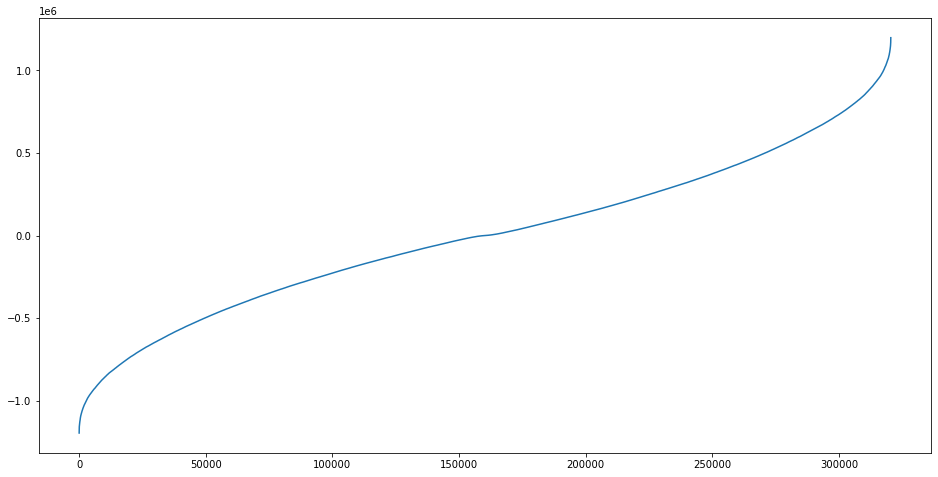

In [83]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(u)
plt.show()